# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [3]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505184 sha256=53fd9049550cd367a3a317ce27b4294714412c6f673ed5d6df5d109dd576b8a1
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [5]:
columns = ['user_id', 'prod_id', 'rating', 'timestamp']
data = pd.read_csv("/content/ratings_Electronics.csv", names=columns)
data = data.drop(columns=['timestamp'])
df = data.copy()

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [6]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [7]:
# We want our users to have at least 50 ratings to be considered
# RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < 50:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [8]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [9]:
# We want our item to have at least 5 ratings to be considered
#RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < 5:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [10]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [11]:
# Check the number of rows and columns and provide observations
rows, cols = df_final.shape
print(rows)
print(cols)

65290
3



*   There are 65290 rows and 3 columns.
*   The columns are user id, product id, and rating.




### **Data types**

In [12]:
# Check Data types and provide observations
data_types = df_final.dtypes
print(data_types)

user_id     object
prod_id     object
rating     float64
dtype: object


**Write your observations here:**


*   User ID: String
*   Product ID: String
*   Rating: Integer/Float





### **Checking for missing values**

In [13]:
# Check for missing values present and provide observations
missing_values = df_final.isnull().sum()
print(missing_values)

user_id    0
prod_id    0
rating     0
dtype: int64


There are no missing values - the dataset is complete.



### **Summary Statistics**

In [14]:
# Summary statistics of 'rating' variable and provide observations
rating_summary = df_final['rating'].describe()
print(rating_summary)

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64



*   The average rating is quite high - a 4.29/5
*   25% of ratings are at or below a 4, while the remaining are above



### **Checking the rating distribution**

<ipython-input-14-f9d9bd77d944>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df_final, palette='viridis')


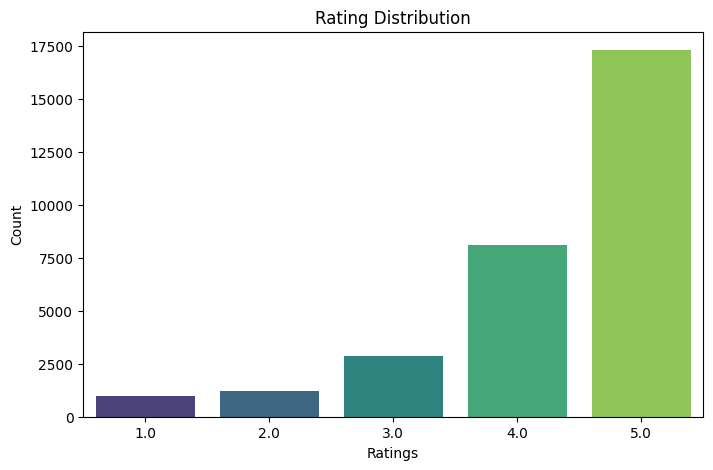

In [ ]:
# Create the bar plot and provide observations
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df_final, palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

**Write your observations here:________**

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
unique_users = df_final['user_id'].nunique()
unique_products = df_final['prod_id'].nunique()
print(unique_users)
print(unique_products)

920
3028


**Write your observations here:_______**

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
top_users = df_final['user_id'].value_counts().head(10)
print(top_users)

user_id
ADLVFFE4VBT8      179
A3OXHLG6DIBRW8    158
A680RUE1FDO8B     140
A1ODOGXEYECQQ8    127
A6FIAB28IS79      125
A17BUUBOU0598B    119
A3LGT6UZL99IW1    118
A2XRMQA6PJ5ZJ8    110
AWPODHOB4GFWL     103
A36K2N527TXXJN    103
Name: count, dtype: int64




*   The most amount of ratings given by a user is 179
*   The user that rated the most was user ADLVFFE4VBT8



**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [15]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()
# Calculate the count of ratings for each product
rating_count = df_final.groupby('prod_id')['rating'].count()
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({
    'average_rating': average_rating,
    'rating_count': rating_count
})
# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='average_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating_head = final_rating.head()

In [16]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def get_top_n_products(data, n, min_interactions):
    # calculate the average rating and count of ratings for each product
    product_stats = data.groupby('prod_id').agg(
        average_rating=('rating', 'mean'),
        rating_count=('rating', 'count')
    )

    # filter products based on the minimum number of interactions
    filtered_products = product_stats[product_stats['rating_count'] >= min_interactions]

    # sort the products by average rating in descending order
    top_products = filtered_products.sort_values(by='average_rating', ascending=False).head(n)

    return top_products


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [17]:
top_5_products_50 = get_top_n_products(df_final, n=5, min_interactions=50)

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [18]:
top_5_products_100 = get_top_n_products(df_final, n=5, min_interactions=100)

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [19]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [20]:
from collections import defaultdict
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [21]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [22]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',  # Cosine similarity
    'user_based': True  # User-user similarity
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
knn_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
knn_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(knn_user_user, k=10, threshold=3.5)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856




*   Since the RMSE was 1.0012, the predicted ratings were 1 unit off from the actual ratings
*   A precision level of 0.855, indicates high confidence in products; when an item is recommended, there's an 85% chance that the user will like it
*   A recall of 0.858 indicates that the system successfully retrieves most of the items a user would've actually liked
*   An F1_score of 0.856 indicates strong performance, meaning that the recommendation system does well in recommending good products to users while minimizing irrelevant suggestions





Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [24]:
# Predicting rating for a sample user with an interacted product
prediction = knn_user_user.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
print(prediction)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 3.40   {'actual_k': 5, 'was_impossible': False}


*   The model predicts that user with userId A3LDPF5FMB782Z would rate product with productId 1400501466 a 3.40/5, based on 5 similar used who rated this item



Below is the **list of users who have not seen the product with product id "1400501466"**.

In [25]:
# Find unique user_id where prod_id is not equal to "1400501466"
unseen_users = df_final[df_final['prod_id'] != "1400501466"]['user_id'].unique()

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [27]:
# Predicting rating for a sample user with a non interacted product
prediction_non_interacted = knn_user_user.predict(
    uid="A34BZM6S9L7QI4",
    iid="1400501466"
)

print(prediction_non_interacted)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}




*   The model predicts that user with userId = A34BZM6S9L7QI4 would rate product with productId = 1400501466 a 4.29/5
*   This prediction cannot be trusted, however, since there were not enough neighbors, which is quite common for new users/items



### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [28]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [20, 30, 40, 50],  # Number of neighbors
    'min_k': [1, 5, 10],  # Minimum neighbors for prediction
    'sim_options': {
        'name': ['cosine', 'pearson', 'msd'],  # Similarity measures to evaluate
        'user_based': [True]  # User-user similarity
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
best_rmse = gs.best_score['rmse']
# Combination of parameters that gave the best RMSE score
best_params = gs.best_params['rmse']

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [29]:
# Using the optimal similarity measure for user-user based collaborative filtering

# Getting best parameters
optimal_k = best_params['k']
optimal_min_k = best_params['min_k']
optimal_similarity = best_params['sim_options']['name']

# Creating an instance of KNNBasic with optimal hyperparameter values
optimal_knn_user_user = KNNBasic(
    k=optimal_k,
    min_k=optimal_min_k,
    sim_options={
        'name': optimal_similarity,
        'user_based': True  # User-user similarity
    },
    verbose=False
)
# Training the algorithm on the trainset
optimal_knn_user_user.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(optimal_knn_user_user, k=10, threshold=3.5)

RMSE: 0.9509
Precision:  0.849
Recall:  0.893
F_1 score:  0.87




*   RMSE improved by 5%, indicating an improvement in predicting ratings - this can be due to better neighbor selection or improved similarity weights
*   Precision didn't change by much; as a result, the system's ability to recommend relevant items was consistent
*   Recall improved, which indicates that more relevant items have been recommended to users, and they're seeing a greater percentage of items they actually liked
*   The F1 score slightly improved, maintaining strong recommendation ability





### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [32]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
prediction_optimized_1 = optimal_knn_user_user.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
baseline_prediction_1 = knn_user_user.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
print(prediction_optimized_1)
print(baseline_prediction_1)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 3.40   {'actual_k': 5, 'was_impossible': False}
user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 3.40   {'actual_k': 5, 'was_impossible': False}


In [33]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction_optimized_2 = optimal_knn_user_user.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
baseline_prediction_2 = knn_user_user.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
print(prediction_optimized_2)
print(baseline_prediction_2)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


*   Hyperparameter tuning did not change the outcome for either prediction; it lowered the error and slightly improved the model's recommendation ability, but not a signficant amount that vastly changed the performance
*   The model already had strong performance to begin with





### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [34]:
# 0 is the inner id of the above user
similar_users = optimal_knn_user_user.get_neighbors(0, k=5)

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [35]:
def get_recommendations(data, user_id, top_n, algo):

    # Convert the Surprise Dataset object to a Pandas DataFrame
    ratings_df = pd.DataFrame(data.raw_ratings, columns=['user_id', 'prod_id', 'rating', 'timestamp'])
    ratings_df = ratings_df.drop(columns=['timestamp'])  # Drop the timestamp column

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = ratings_df.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [36]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
user_id = "A3LDPF5FMB782Z"

# Get all internal item IDs in the training set
all_items = [item for item in trainset.all_items()]

# Convert internal item IDs to raw product IDs
all_product_ids = [trainset.to_raw_iid(item) for item in all_items]

# Get the items already interacted with by the user
# **Change:** Extract inner item ID from the tuple before passing to to_raw_iid
interacted_items = [trainset.to_raw_iid(item[0]) for item in trainset.ur[trainset.to_inner_uid(user_id)]]

# Filter out already interacted items
recommendable_items = [item for item in all_product_ids if item not in interacted_items]

predictions = []
for item in recommendable_items:
    prediction = optimal_knn_user_user.predict(uid=user_id, iid=item)
    predictions.append((item, prediction.est))

# Sort predictions by predicted rating in descending order
sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:5]

In [37]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(sorted_predictions, columns=["prod_id", "predicted_ratings"])

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [38]:
# Declaring the similarity options
sim_options_item = {
    'name': 'cosine',  # Similarity measure
    'user_based': False  # Item-item similarity
}
# KNN algorithm is used to find desired similar items. Use random_state=1
item_item_knn = KNNBasic(sim_options=sim_options_item, random_state=1, verbose=False)
# Train the algorithm on the trainset, and predict ratings for the test set
item_item_knn.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(item_item_knn, k=10, threshold=3.5)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841



*   The user-user recommendation system performs better than the item-item recommendation system, since it has a lower RMSE
*   Since users interact with items consistently, it is understandable that the RMSE is lower



Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [40]:
# Predicting rating for a sample user with an interacted product
prediction_interacted = item_item_knn.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
print(prediction_interacted)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.27   {'actual_k': 22, 'was_impossible': False}




*   The predicted rating was 4.27/5, which is quite strong; the user really liked the product
*   The number of neighbors was 22; as a result, it was a reliable prediction with high accuracy





Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [42]:
# Predicting rating for a sample user with an interacted product
prediction_interacted = item_item_knn.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
print(prediction_interacted)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}



*   The predicted rating was 4.29/5, which is quite strong; the user really liked the product
*   This rating is not believable, though, since there were not enough neighbors. This is expected, as it was a product never interacted with before, and the user doesn't have a lot of neighbors that havve interacted with it
*  It could be a newer product, or a product that isn't super well-known







### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [43]:
# Setting up the parameter grid for hyperparameter tuning
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['msd', 'cosine'],  # Similarity metrics
        'user_based': [False]  # Item-item similarity
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
grid_search.fit(data)

# Find the best RMSE score
best_rmse = grid_search.best_score['rmse']

# Find the combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [44]:
# Extracting the best hyperparameters from the GridSearchCV results
optimal_k = best_params['k']
optimal_min_k = best_params['min_k']
optimal_similarity = best_params['sim_options']['name']

# Creating an instance of KNNBasic with optimal hyperparameter values for item-item similarity
optimal_item_item_knn = KNNBasic(
    k=optimal_k,
    min_k=optimal_min_k,
    sim_options={
        'name': optimal_similarity,
        'user_based': False  # Item-item similarity
    },
    verbose=False
)

# Training the algorithm on the trainset
optimal_item_item_knn.fit(trainset)

# Compute precision@k, recall@k, F1-score, and RMSE
precision_recall_at_k(optimal_item_item_knn, k=10, threshold=3.5)


RMSE: 0.9578
Precision:  0.839
Recall:  0.88
F_1 score:  0.859



*   The RMSE decreased, leading to better rating accuracy, which can be attributed to better neighbor selection and/or adjusted similarity weightings
*   Precision didn't drastically change, indicating that the model still recommends the same proportion of relevant items as before

*   Improved recall - the model is retrieving more relevant items. This can be attributed to more neighbors, and less overfitting
*   Improved F1 Score - the model can now recommend more relevant items without significantly increasing irrelevant ones





### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [45]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
optimized_prediction_1 = optimal_item_item_knn.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
baseline_prediction_1 = item_item_knn.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
print(optimized_prediction_1)
print(baseline_prediction_1)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.71   {'actual_k': 20, 'was_impossible': False}
user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.27   {'actual_k': 22, 'was_impossible': False}


In [46]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
optimized_prediction_2 = optimal_item_item_knn.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
baseline_prediction_2 = item_item_knn.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
print(optimized_prediction_2)
print(baseline_prediction_2)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}



*   In the first prediction, the optimized models yields a higher prediction of 4.71 as opposed to 4.27, with fewer neighbors. This means that hyperparameter tuning improved the prediction, and made sure to select less neighbors that were more reliable to avoid capturing noise.
*   The second prediction did not improve with hyperparameter tuning, which suggests a new product that doesn't have a lot of historical data/previous interactions. Therefore, tuning the parameters primarily benefits products that have been interacted with before.



### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [47]:
similar_items = optimal_item_item_knn.get_neighbors(0, k=5)
similar_item_ids = [trainset.to_raw_iid(inner_id) for inner_id in similar_items]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [50]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
user_id = "A1A5KUIIIHFF4U"
recommendations = get_recommendations(data, user_id, 5, optimal_item_item_knn)
print(recommendations)

[('1400532655', 4.292024046561495), ('1400599997', 4.292024046561495), ('9983891212', 4.292024046561495), ('B00000DM9W', 4.292024046561495), ('B00000J1V5', 4.292024046561495)]


In [51]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommendations, columns=["prod_id", "predicted_ratings"])

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [52]:
# Using SVD matrix factorization. Use random_state = 1
svd_model = SVD(random_state=1)
# Training the algorithm on the trainset
svd_model.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_model, k=10, threshold=3.5)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


*   This model has the lowest RMSE, making it the most accurate with ratings
*   The precision slightly increased, suggesting a greater proportion of relevant items being recommended
*   Recall didn't change much in comparison to the Item-Item based collaborative filtering, but was still strong; as a result, the SVD model still retrieves a high amount of relevant items like before
*   The F1 score slightly improved, suggesting a better recommendation ability





**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [54]:
# Making prediction
predicted_rating = svd_model.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
print(predicted_rating)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.08   {'was_impossible': False}




*   The model predicted that user with userId = A3LDPF5FMB782Z would rate product with productId = 1400501466 a 4.08/5, which is moderately strong
*   The prediction is reliable since was_impossible = False; as a result, the model had sufficient data
*   By using SVD, the model was able to learn the latent patterns of the data, leading to better inference in predicted ratings





**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [55]:
# Making prediction
predicted_rating_2 = svd_model.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
print(predicted_rating_2)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}




*   The model predicted that user with userId = A34BZM6S9L7QI4 would rate product with productId = 1400501466 a 4.40/5, which is quite strong
*   The prediction is reliable since was_impossible = False; as a result, the model had sufficient data
*   By using SVD, the model was able to learn the latent patterns of the data, leading to better inference in predicted ratings



### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [56]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [10, 20, 30],  # Number of SGD iterations
    'lr_all': [0.002, 0.005, 0.01],  # Learning rates
    'reg_all': [0.02, 0.1, 0.2]  # Regularization terms
}
# Performing 3-fold gridsearch cross-validation
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting data
grid_search.fit(data)
# Best RMSE score
best_rmse = grid_search.best_score['rmse']
# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [57]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
optimized_svd_model = SVD(
    n_epochs=best_params['n_epochs'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    random_state=1
)
# Train the algorithm on the trainset
optimized_svd_model.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(optimized_svd_model, k=10, threshold=3.5)

RMSE: 0.8811
Precision:  0.853
Recall:  0.882
F_1 score:  0.867


*   The RMSE slightly decreased, meaning that hyperparameter tuning helped improve generalization and reduce overfitting to specific users/items
*   The precision stayed the same, meaning that the model was already performing optimally and that further tuning wouldn't have significantly impacted it
*   The recall increased slightly, indicating that the model is retrieving slightly more relevant items for users
*   The F1 score went up slightly, indicating better overall performance and recommendation ability; hyperparameter tuning helped refine the model, without drastically changing the outcome




### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [58]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
optimized_prediction_1 = optimized_svd_model.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
baseline_prediction_1 = svd_model.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
print(optimized_prediction_1)
print(baseline_prediction_1)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.08   {'was_impossible': False}
user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.08   {'was_impossible': False}


In [59]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
optimized_prediction_2 = optimized_svd_model.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
baseline_prediction_2 = svd_model.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
print(optimized_prediction_2)
print(baseline_prediction_2)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.24   {'was_impossible': False}
user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


### **Conclusion and Recommendations**

**Concluding Takeaways:**
*   The optimized SVD model has the highest rating ability and generalizability, making it the best-performing
*   The user-user collaborative filtering model still performed well, but struggled when it came to newer items or products; as a result, it needs significant overlap/historical data to perform efficiently
*   The item-item collaborative filtering model, despite improved recall with hyperparameter tuning, is not ideal for sparse datasets with low correlation. It works best for strong item-item relationships.


**Recommendations:**

*   Use hybrid models (ex. Optimized SVD + User-User CF) for improved generalization, especially to unseen data/unfamiliar users or items
*   For large-scale e-commerce platforms like Amazon, looking into deep learning models, or alternatives to SVD like Neural Collaborative Filtering or Factorization Machines, would lead to higher scalability in the model and better results overall

